# All Imports

In [3]:
import math
from tqdm import tqdm
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


# Commands

In [5]:
bechmarks=("gcc", "mcf", "namd", "lbm", "xalancbmk")

# Data Extraction

In [6]:
def data_splitter(data_path):
    with open(data_path, "r") as file:
        data = file.readlines()
    data = [line.strip().split() for line in data][1:]
    split_indices = []
    for i in range(len(data)):
        if data[i][0] == "#":
            split_indices.append(i)
    assert len(split_indices) == 4
    meta_data = {
        "RAW": data[split_indices[0]+1:split_indices[1]],
        "WAR": data[split_indices[1]+1:split_indices[2]],
        "WAW": data[split_indices[2]+1:split_indices[3]],
        "SL": data[split_indices[3]+1:],
    }
    return meta_data

def metadata_parser(metadata):
    parsed_data = {key: [] for key in metadata.keys()}
    for key in metadata.keys():
        for data in metadata[key]:
            parsed_data[key].append([int(data[0].replace(',', '')), int(data[1])])
    return parsed_data

def get_all_data():
    data = {key: 0 for key in bechmarks}
    for benchmark in tqdm(bechmarks):
        data_path = f"data/{benchmark}.count"
        metadata = data_splitter(data_path)
        parsed_data = metadata_parser(metadata)
        data[benchmark] = parsed_data
    return data

all_data = get_all_data()

100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


# Data Analysis

In [50]:
def avergage_distance():
    average = 0
    total = 0
    for benchmark in bechmarks:
        for key in all_data[benchmark].keys():
            for data in all_data[benchmark][key]:
                # Ignoring outliers of distance > 500
                if data[0]>500: continue
                average += data[0]*data[1]
                total += data[1]
    return average/total

average = avergage_distance()
print(f"Average distance: {average}")

Average distance: 31.080069678733672


# Transformers

In [102]:
def log(arr, base=2):
    return [math.log(x, base) for x in arr]

def smoothner(arr, window=0.02):
    smoothed_arr = []
    window_size = int(len(arr)*window)
    for i in range(len(arr)):
        if i < window_size:
            smoothed_arr.append(sum(arr[:i+1])/(i+1))
        else:
            smoothed_arr.append(sum(arr[i-window_size+1:i+1])/window_size)
    assert len(smoothed_arr) == len(arr)
    return smoothed_arr

# Plotting

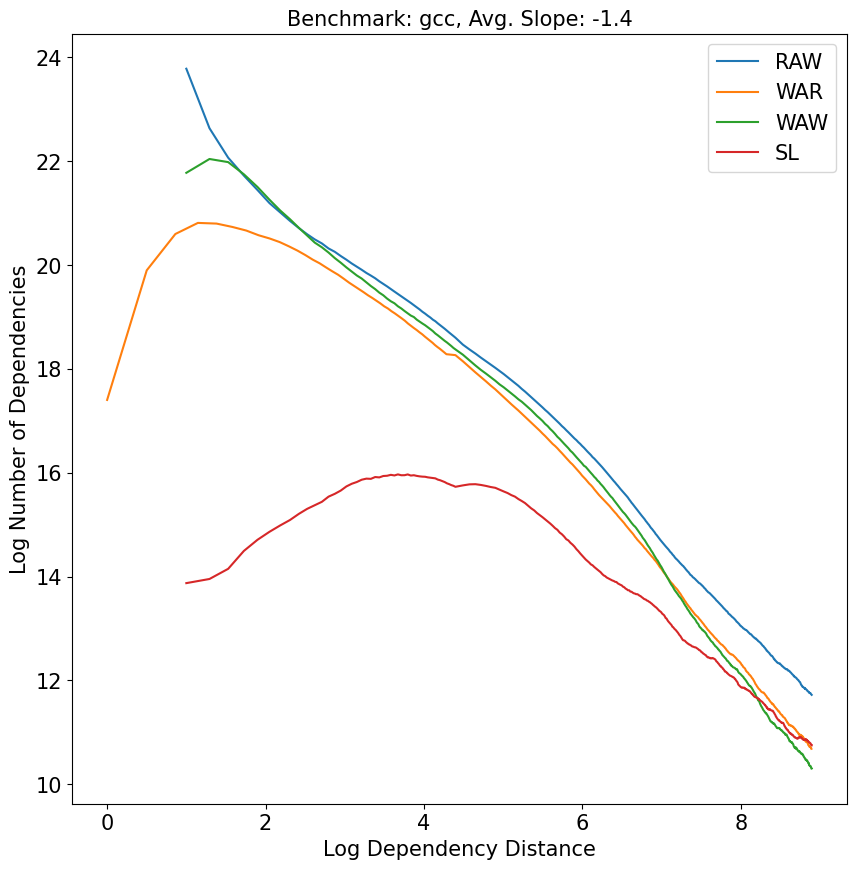

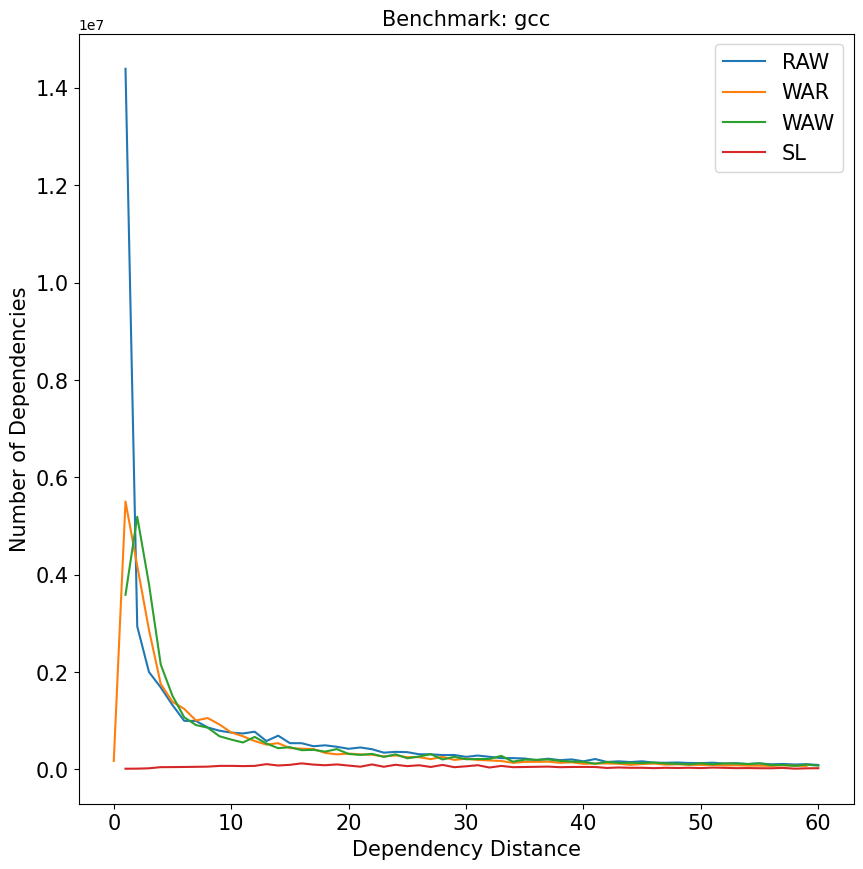

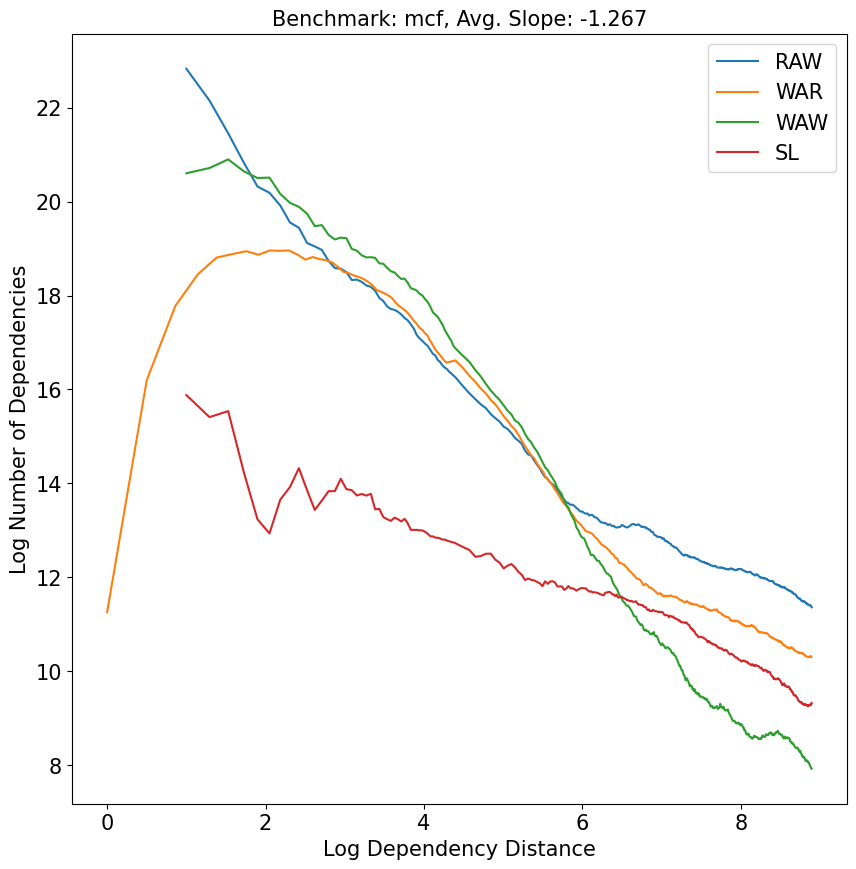

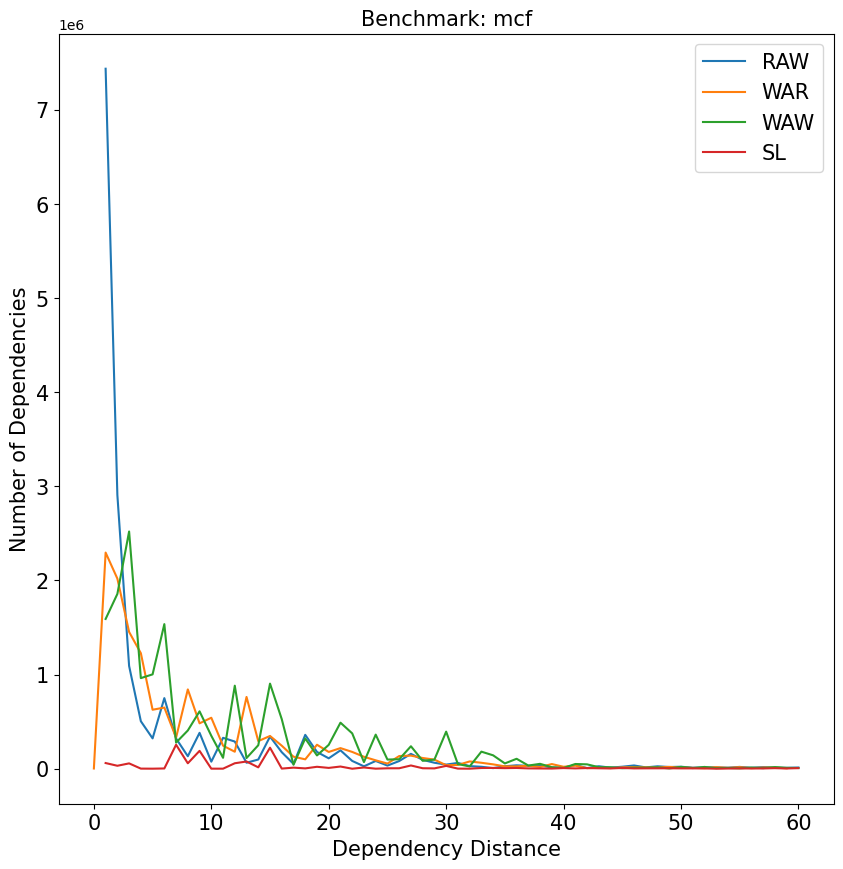

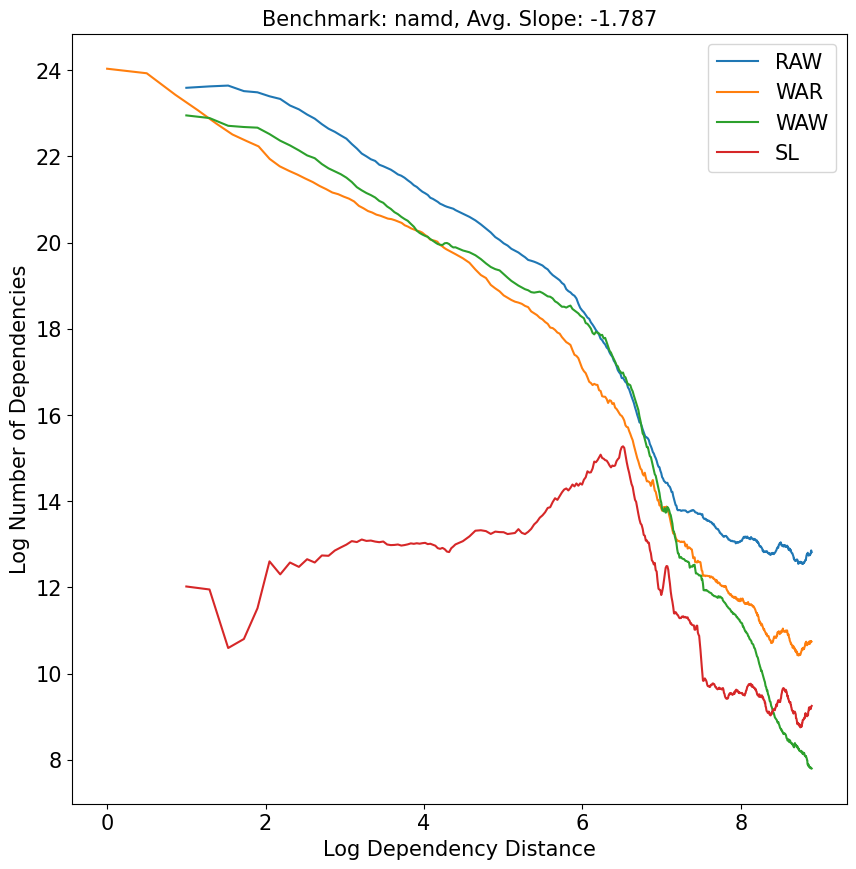

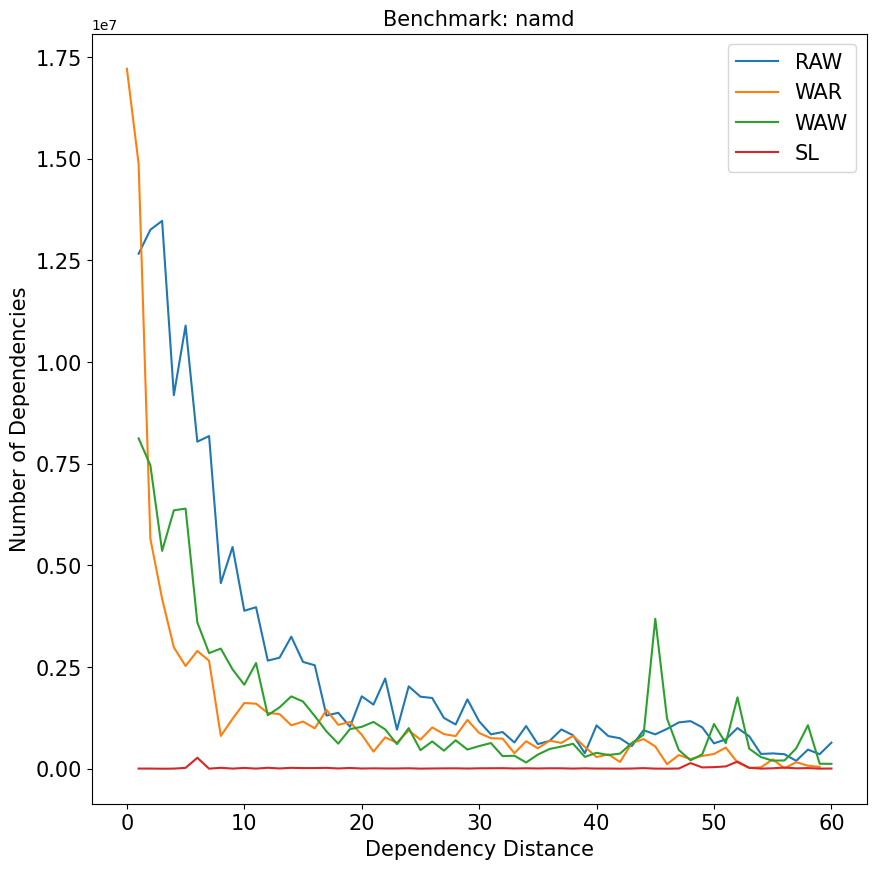

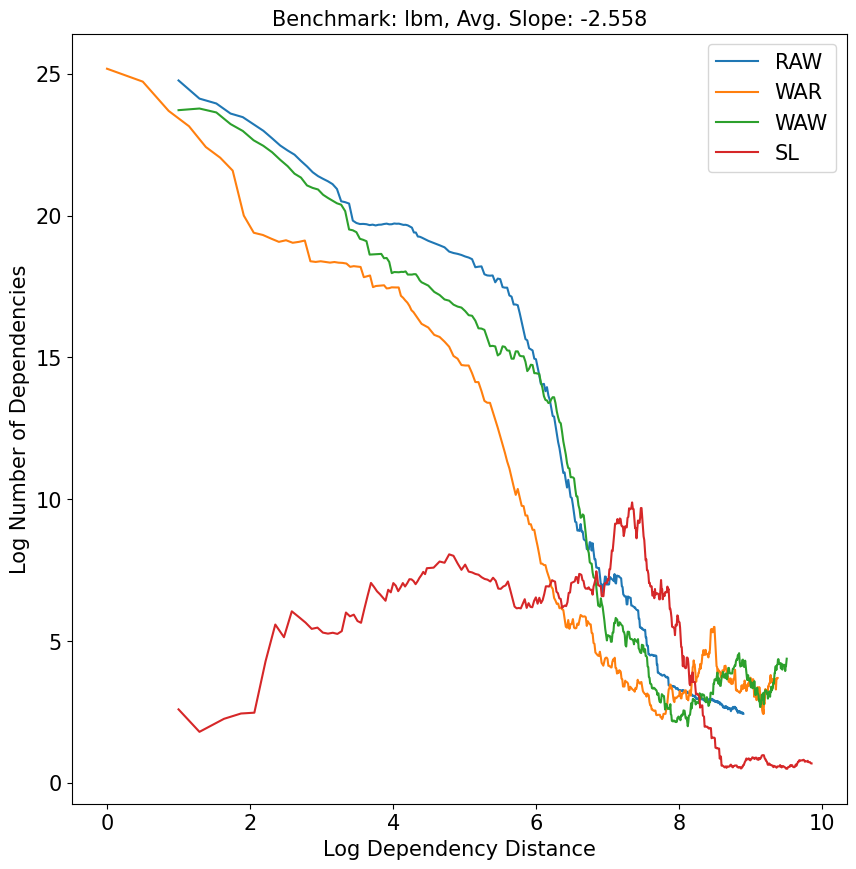

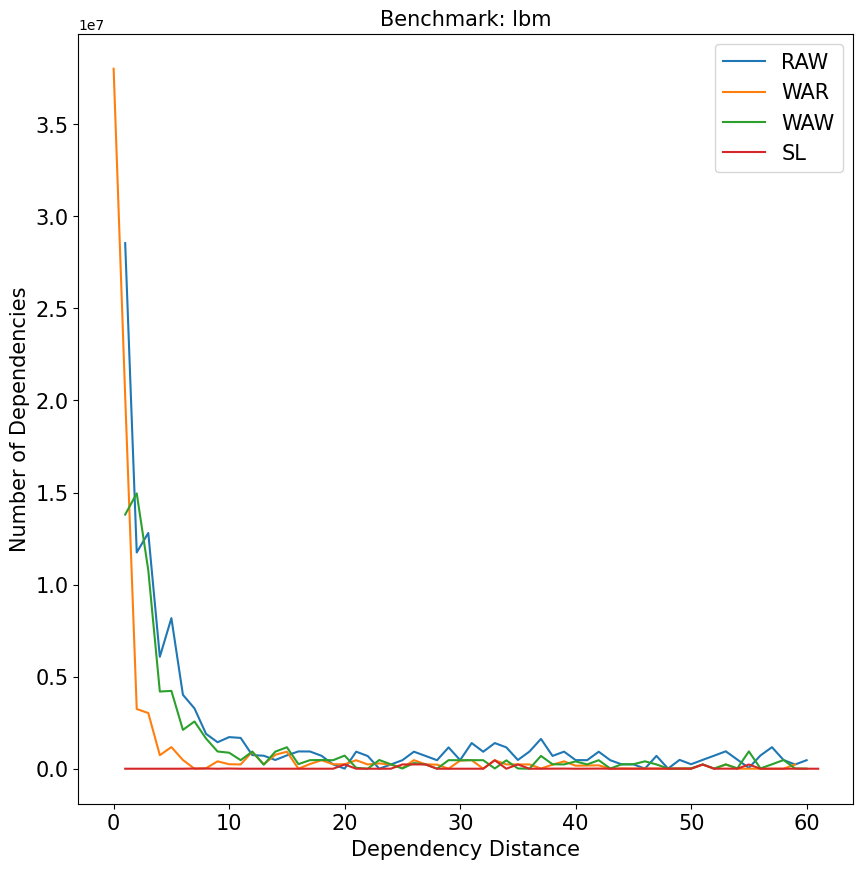

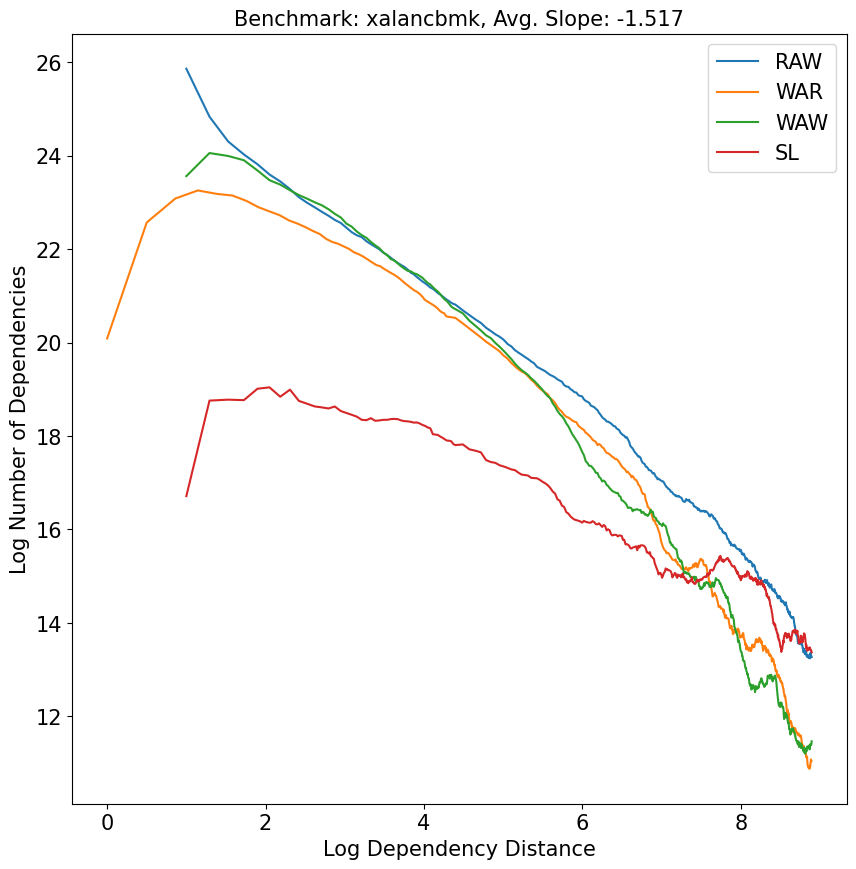

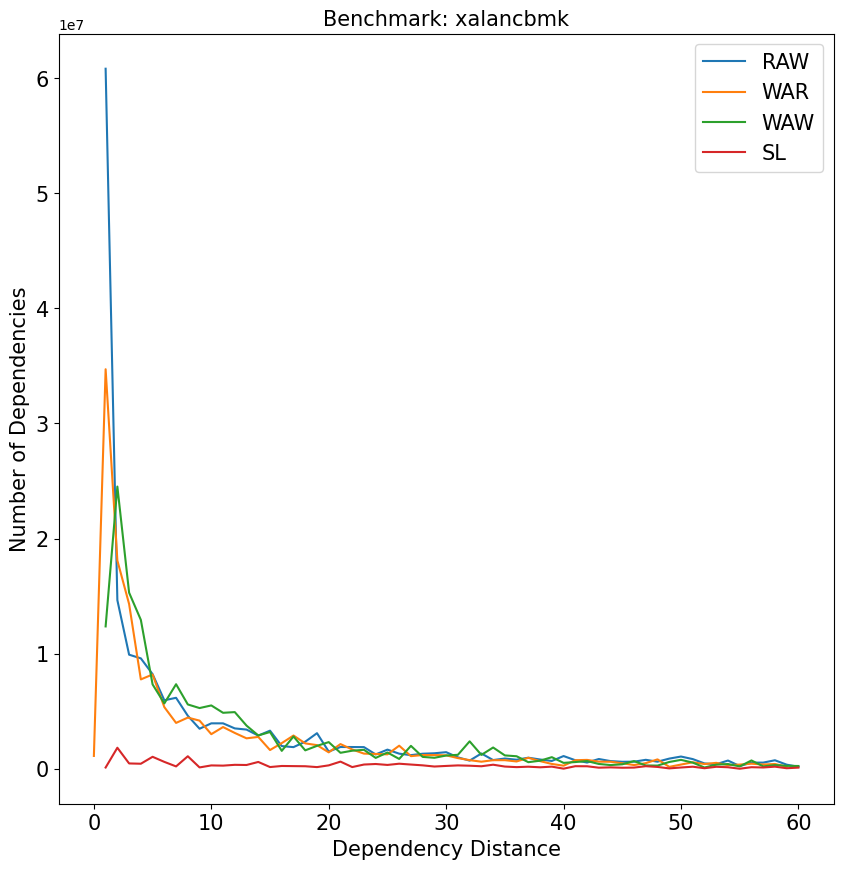

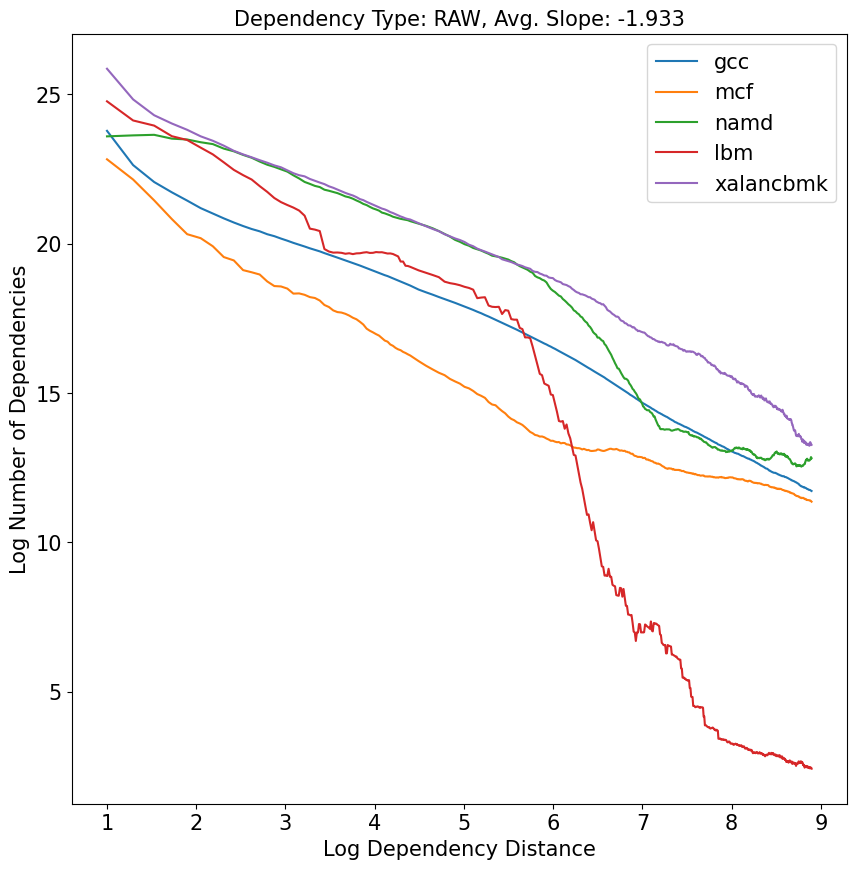

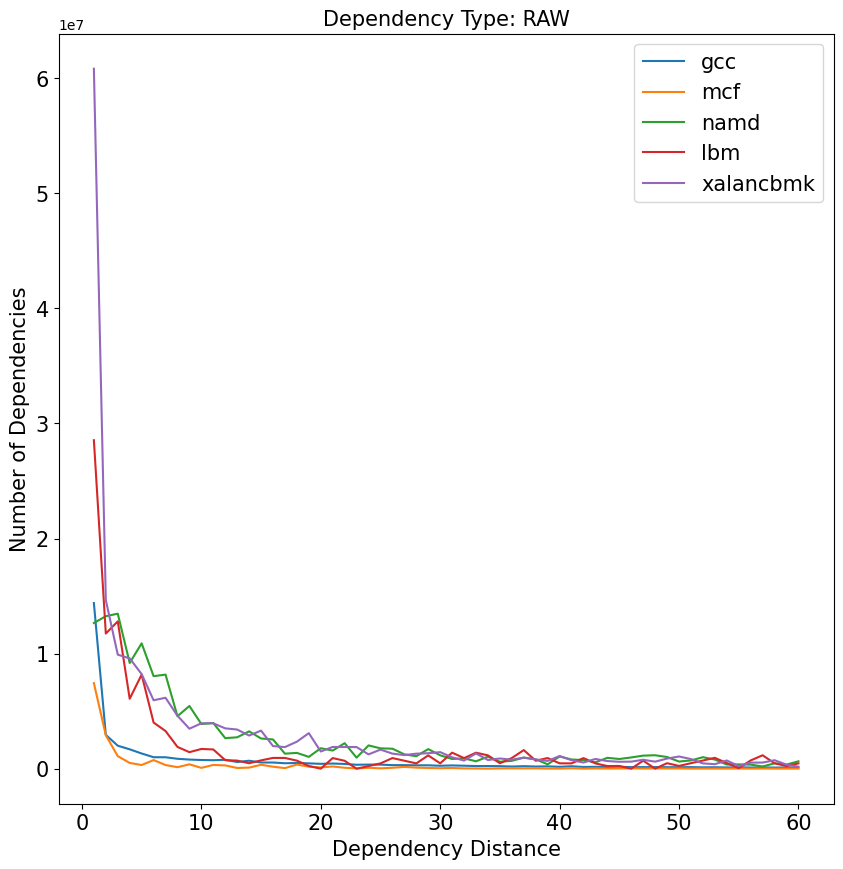

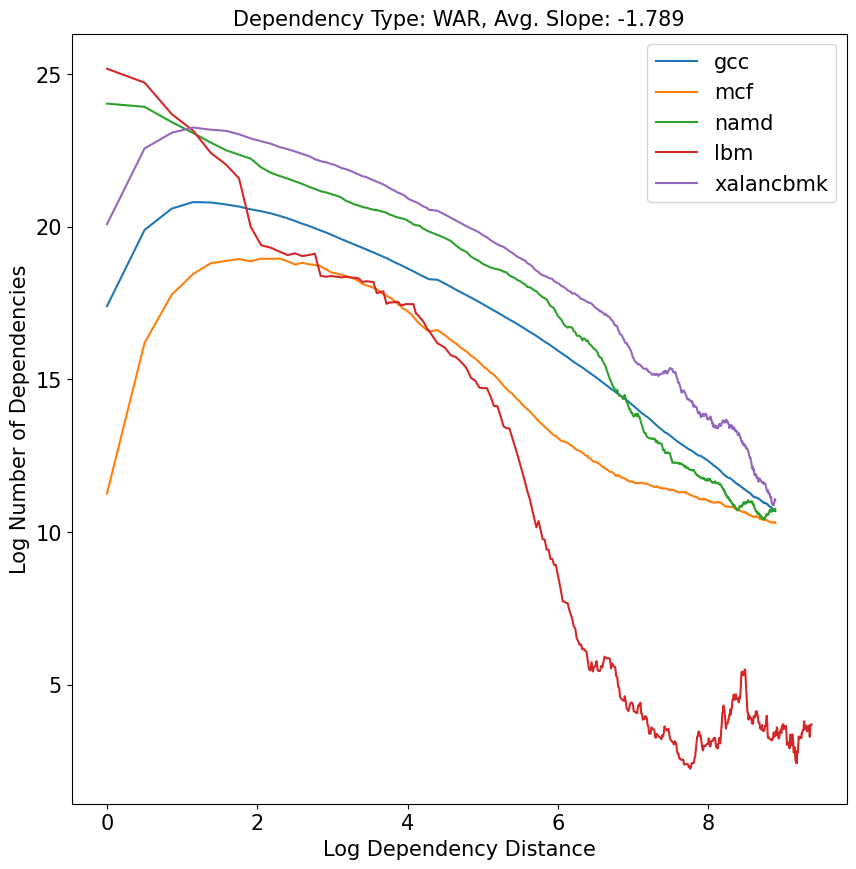

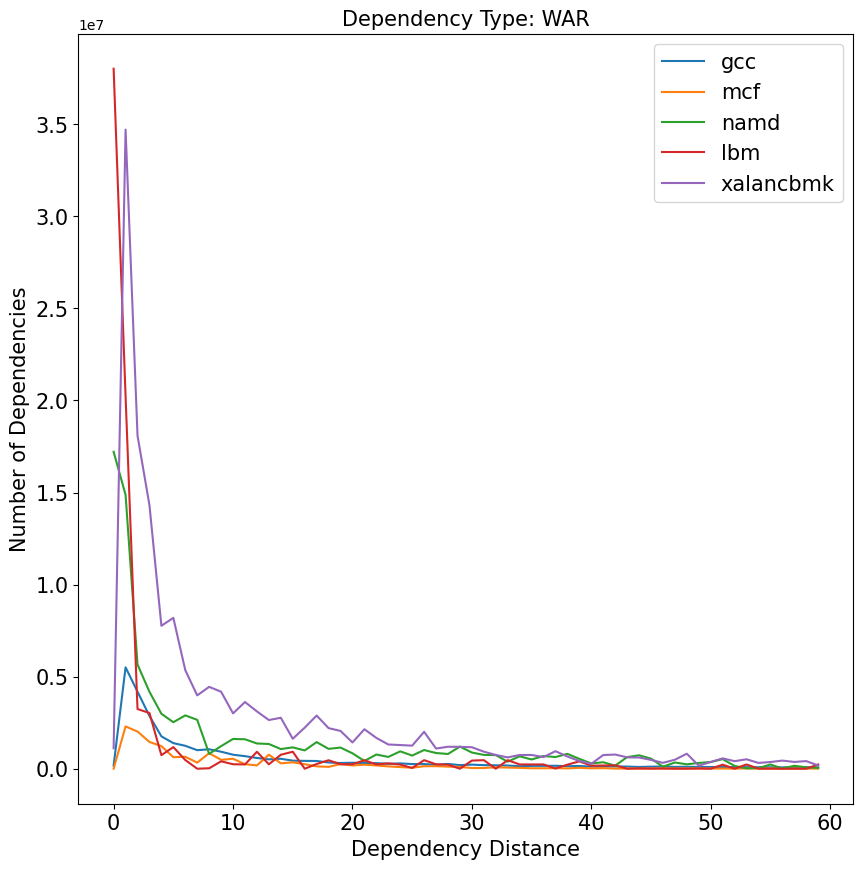

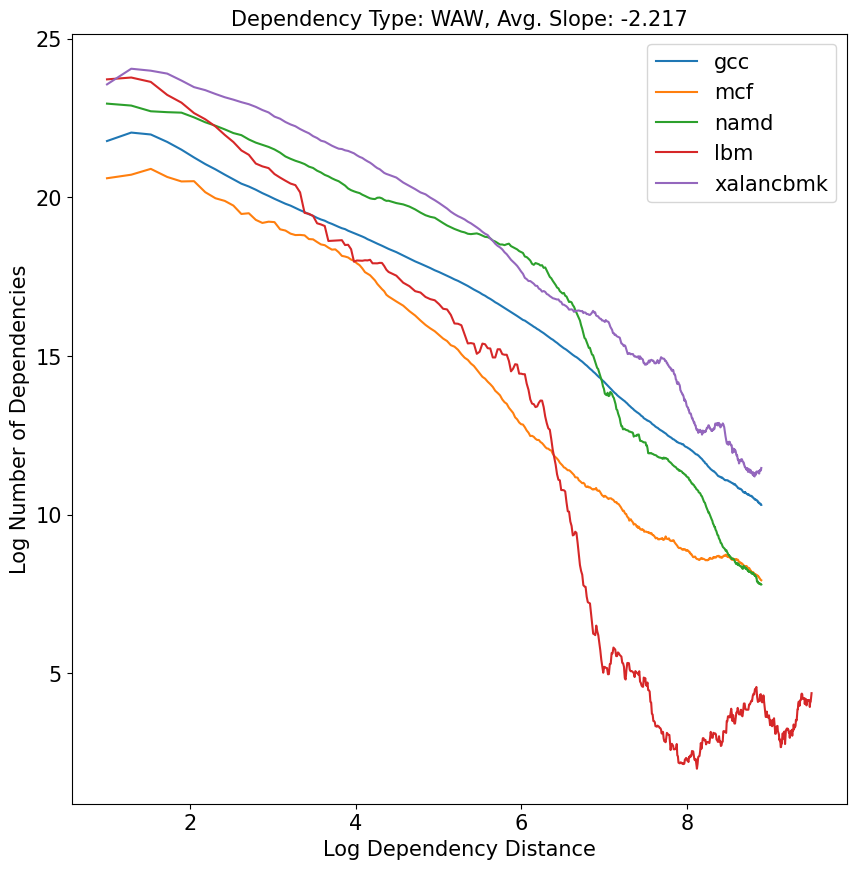

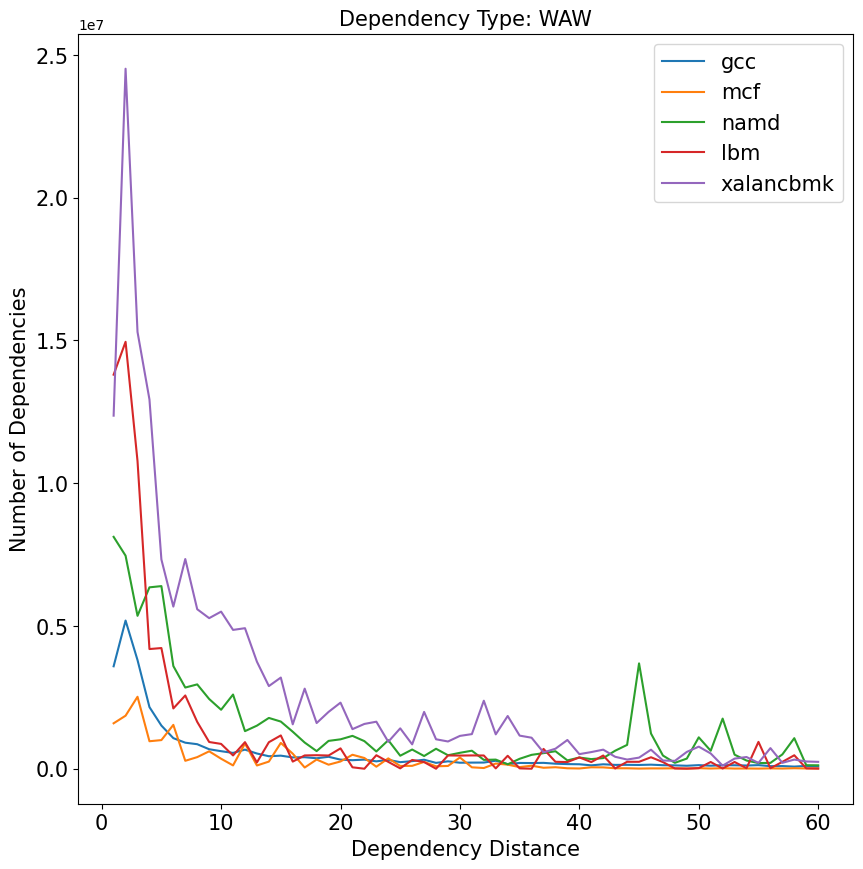

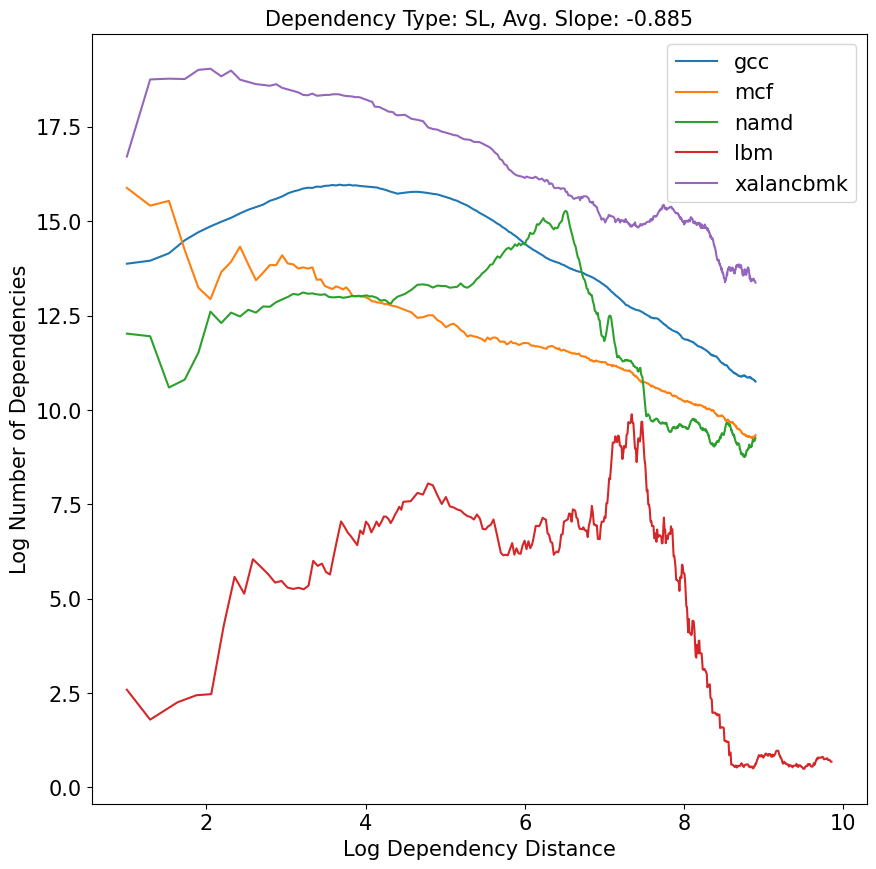

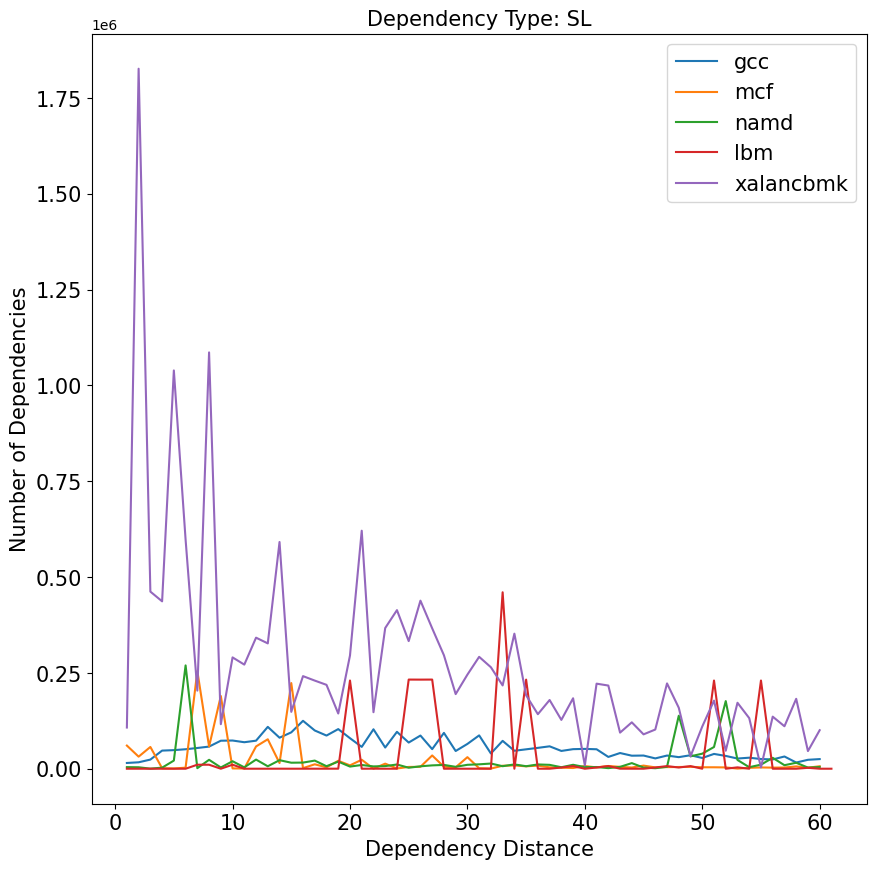

In [108]:
def plotter(all_data, benchmark=None, dep_type=None, one_benchmark=True, take_log=False, file_path=None):
    plt.figure(figsize=(10, 10))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    slope = 0
    if one_benchmark:
        for dep_type in all_data[benchmark].keys():
            data = all_data[benchmark][dep_type]
            if take_log:
                X = smoothner(log([x[0]+1 for x in data][:500]))
                Y = smoothner(log([x[1] for x in data][:500]))
                slope += linregress(X, Y).slope
            else:
                X = [x[0] for x in data][:60]
                Y = [x[1] for x in data][:60]
            plt.plot(X, Y)
        if not take_log:
            plt.title(f"Benchmark: {benchmark}", fontsize=15)
            plt.xlabel("Dependency Distance", fontsize=15)
            plt.ylabel("Number of Dependencies", fontsize=15)
        else:
            plt.title(f"Benchmark: {benchmark}, Avg. Slope: {round(slope/len(all_data[benchmark].keys()), 3)}", fontsize=15)
            plt.xlabel("Log Dependency Distance", fontsize=15)
            plt.ylabel("Log Number of Dependencies", fontsize=15)
        plt.legend(all_data[benchmark].keys(), fontsize=15)
        if file_path: plt.savefig(file_path)
    else:
        for benchmark in all_data.keys():
            data = all_data[benchmark][dep_type]
            if take_log:
                X = smoothner(log([x[0]+1 for x in data][:500]))
                Y = smoothner(log([x[1] for x in data][:500]))
                slope += linregress(X, Y).slope
            else:
                X = [x[0] for x in data][:60]
                Y = [x[1] for x in data][:60]
            plt.plot(X, Y)
        if not take_log:
            plt.title(f"Dependency Type: {dep_type}", fontsize=15)
            plt.xlabel("Dependency Distance", fontsize=15)
            plt.ylabel("Number of Dependencies", fontsize=15)
        else:
            plt.title(f"Dependency Type: {dep_type}, Avg. Slope: {round(slope/len(all_data.keys()), 3)}", fontsize=15)
            plt.xlabel("Log Dependency Distance", fontsize=15)
            plt.ylabel("Log Number of Dependencies", fontsize=15)
        plt.legend(all_data.keys(), fontsize=15)
        if file_path: plt.savefig(file_path)

# One benchmark plots
for benchmark in bechmarks:
    plotter(all_data, benchmark=benchmark, take_log=True, file_path=f"plots/{benchmark}_log.png")
    plotter(all_data, benchmark=benchmark, take_log=False, file_path=f"plots/{benchmark}.png")
    
# One dependency type plots
for dep_type in all_data[bechmarks[0]].keys():
    plotter(all_data, dep_type=dep_type, one_benchmark=False, take_log=True, file_path=f"plots/{dep_type}_log.png")
    plotter(all_data, dep_type=dep_type, one_benchmark=False, take_log=False, file_path=f"plots/{dep_type}.png")
